In [0]:
!nvidia-smi

Tue Dec 10 19:03:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pandas as pd
import numpy as np
from PIL import Image
import shutil
from torchvision import models
import torch.nn as nn
import torch
import json
import time
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from zipfile import ZipFile 
from keras.preprocessing.image import load_img, save_img, img_to_array
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with ZipFile("/content/gdrive/My Drive/Painting Dataset/train.zip", 'r') as zip_f: 
  zip_f.extractall(path='/content') 
with ZipFile("/content/gdrive/My Drive/Painting Dataset/val.zip", 'r') as zip_f: 
  zip_f.extractall(path='/content')    

In [0]:
train_directory = 'train'
val_directory = 'val'
preprocess = transforms.Compose([
              transforms.RandomResizedCrop(224), # random resized crop is used 
                                                 # for data augmentation
              transforms.ToTensor(), 
              transforms.Normalize((0.4914, 0.4822, 0.4465),
                                   (0.2023, 0.1994, 0.2010))
              ])
train_data = ImageFolder(train_directory, transform=preprocess)

val_data = ImageFolder(val_directory, transform=preprocess)

In [0]:
n_category = 50
# Resnet 18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, n_category)
# Resnet 50
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, n_category)
# Resnet 101
resnet101 = models.resnet101(pretrained=True)
resnet101.fc = nn.Linear(2048, n_category)
# GoogleNet
googleNet = models.googlenet(pretrained=True)
googleNet.fc = nn.Linear(1024, n_category)
# VGG 11 with batch normalization
vgg11 = models.vgg11_bn(pretrained=False)
vgg11.classifier[6] = nn.Linear(4096, n_category)
# VGG 19 with batch normalization
vgg19 = models.vgg19_bn(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, n_category)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 18.8MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 38.3MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:06<00:00, 28.9MB/s]
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 36.9MB/s]
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:09<00:00, 60.7MB/s]


In [0]:
!pip install tqdm --upgrade

     |████████████████████████████████| 61kB 3.4MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
from tqdm.notebook import tqdm
import torch.optim as optim
from sklearn.metrics import f1_score, recall_score, precision_score
def train(classifier, criterion, optimizer, trainLoader, device):
    epoch_loss = 0
    epoch_correct = 0
    classifier.train()
    record_pred = torch.FloatTensor().cpu()
    record_gt = torch.LongTensor().cpu()
    for i, (x, y) in tqdm(enumerate(trainLoader)):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        predictions = classifier(x)
        loss = criterion(predictions, y)
        # print('predictions.size()',predictions.size())
        epoch_correct += torch.eq(torch.argmax(predictions, dim=1), y).sum().item()

        record_pred = torch.cat([record_pred, torch.argmax(predictions, dim=1).cpu().type(torch.FloatTensor)], dim=0)
        record_gt = torch.cat([record_gt, y.cpu()], dim=0)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    record_pred = record_pred.view(-1)
    record_gt = record_gt.view(-1)
    f1 = f1_score(record_gt, record_pred, average='weighted')
    precision = precision_score(record_gt, record_pred, average='weighted')
    recall = recall_score(record_gt, record_pred, average='weighted')
    print('Train f1', f1)
    print('Train precision', precision)
    print('Train recall', recall)
    return epoch_loss / len(trainLoader.dataset), epoch_correct / len(trainLoader.dataset), f1, precision, recall

def evaluate(classifier, criterion, optimizer, validLoader, device):
  epoch_loss = 0
  epoch_correct = 0
  classifier.eval()
  record_pred = torch.FloatTensor().cpu()
  record_gt = torch.LongTensor().cpu()
  with torch.no_grad():
      for i, (x, y) in tqdm(enumerate(validLoader)):
          x, y = x.to(device), y.to(device)

          predictions = classifier(x)
          
          loss = criterion(predictions, y)
          record_pred = torch.cat([record_pred, torch.argmax(predictions, dim=1).cpu().type(torch.FloatTensor)], dim=0)
          record_gt = torch.cat([record_gt, y.cpu()], dim=0)

          epoch_loss += loss.item()
          epoch_correct += torch.eq(torch.argmax(predictions, dim=1), y).sum().item()
      record_pred = record_pred.view(-1)
      record_gt = record_gt.view(-1)
      f1 = f1_score(record_gt, record_pred, average='weighted')
      precision = precision_score(record_gt, record_pred, average='weighted')
      recall = recall_score(record_gt, record_pred, average='weighted')
      print('Val f1', f1)
      print('Val precision', precision)
      print('Val recall', recall)
  return epoch_loss / len(validLoader.dataset), epoch_correct / len(validLoader.dataset)

def plot_result(train_acc, val_acc, train_loss, val_loss):
  epochs = np.arange(0, 60)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi=600)
  ax1.set_title('Train and Validation Accuracy over Epochs')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.plot(epochs, train_acc, label='training accuracy')
  ax1.plot(epochs, val_acc, label='validation accuracy')
  ax1.legend()

  ax2.set_title('Train and Validation Loss over Epochs')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.plot(epochs, train_loss, label='training loss')
  ax2.plot(epochs, val_loss, label='validation loss')
  ax2.legend()
  fig.savefig('vgg11_loss_acc(2).png', dpi=600)

In [0]:
def train_model(classifier, criterion, optimizer, 
                trainSet, testSet, scheduler=None, n_epochs = 60):
    params = {  
        'batch_size':64,
        'shuffle':True,
        'num_workers':0,
    }
    train_ls_acc, valid_ls_acc = [], []
    for epoch in range(n_epochs):
        scheduler.step()
        print('Epoch:', epoch,'LR:', scheduler.get_lr())

        train_loader = DataLoader(trainSet, **params)
        val_loader = DataLoader(testSet, **params)

        start_time = time.time()
        
        train_loss, train_acc, f1_t, p_t, r_t = train(classifier, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = evaluate(classifier, criterion, optimizer, val_loader, device)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        epoch_mins = int(elapsed_time/60)
        epoch_secs = int(elapsed_time - epoch_mins*60)
        
        train_ls_acc.append((train_loss, train_acc))
        valid_ls_acc.append((valid_loss, valid_acc))
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return train_ls_acc, valid_ls_acc

In [0]:
from torch.optim.lr_scheduler import StepLR
model = vgg11.to(device)
criterion = nn.CrossEntropyLoss().to(device)
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size = 16, gamma = 0.96)
train_ls_acc, valid_ls_acc = train_model(model, criterion, optimizer, train_data, val_data, scheduler=scheduler)

Epoch: 0 LR: [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


KeyboardInterrupt: ignored

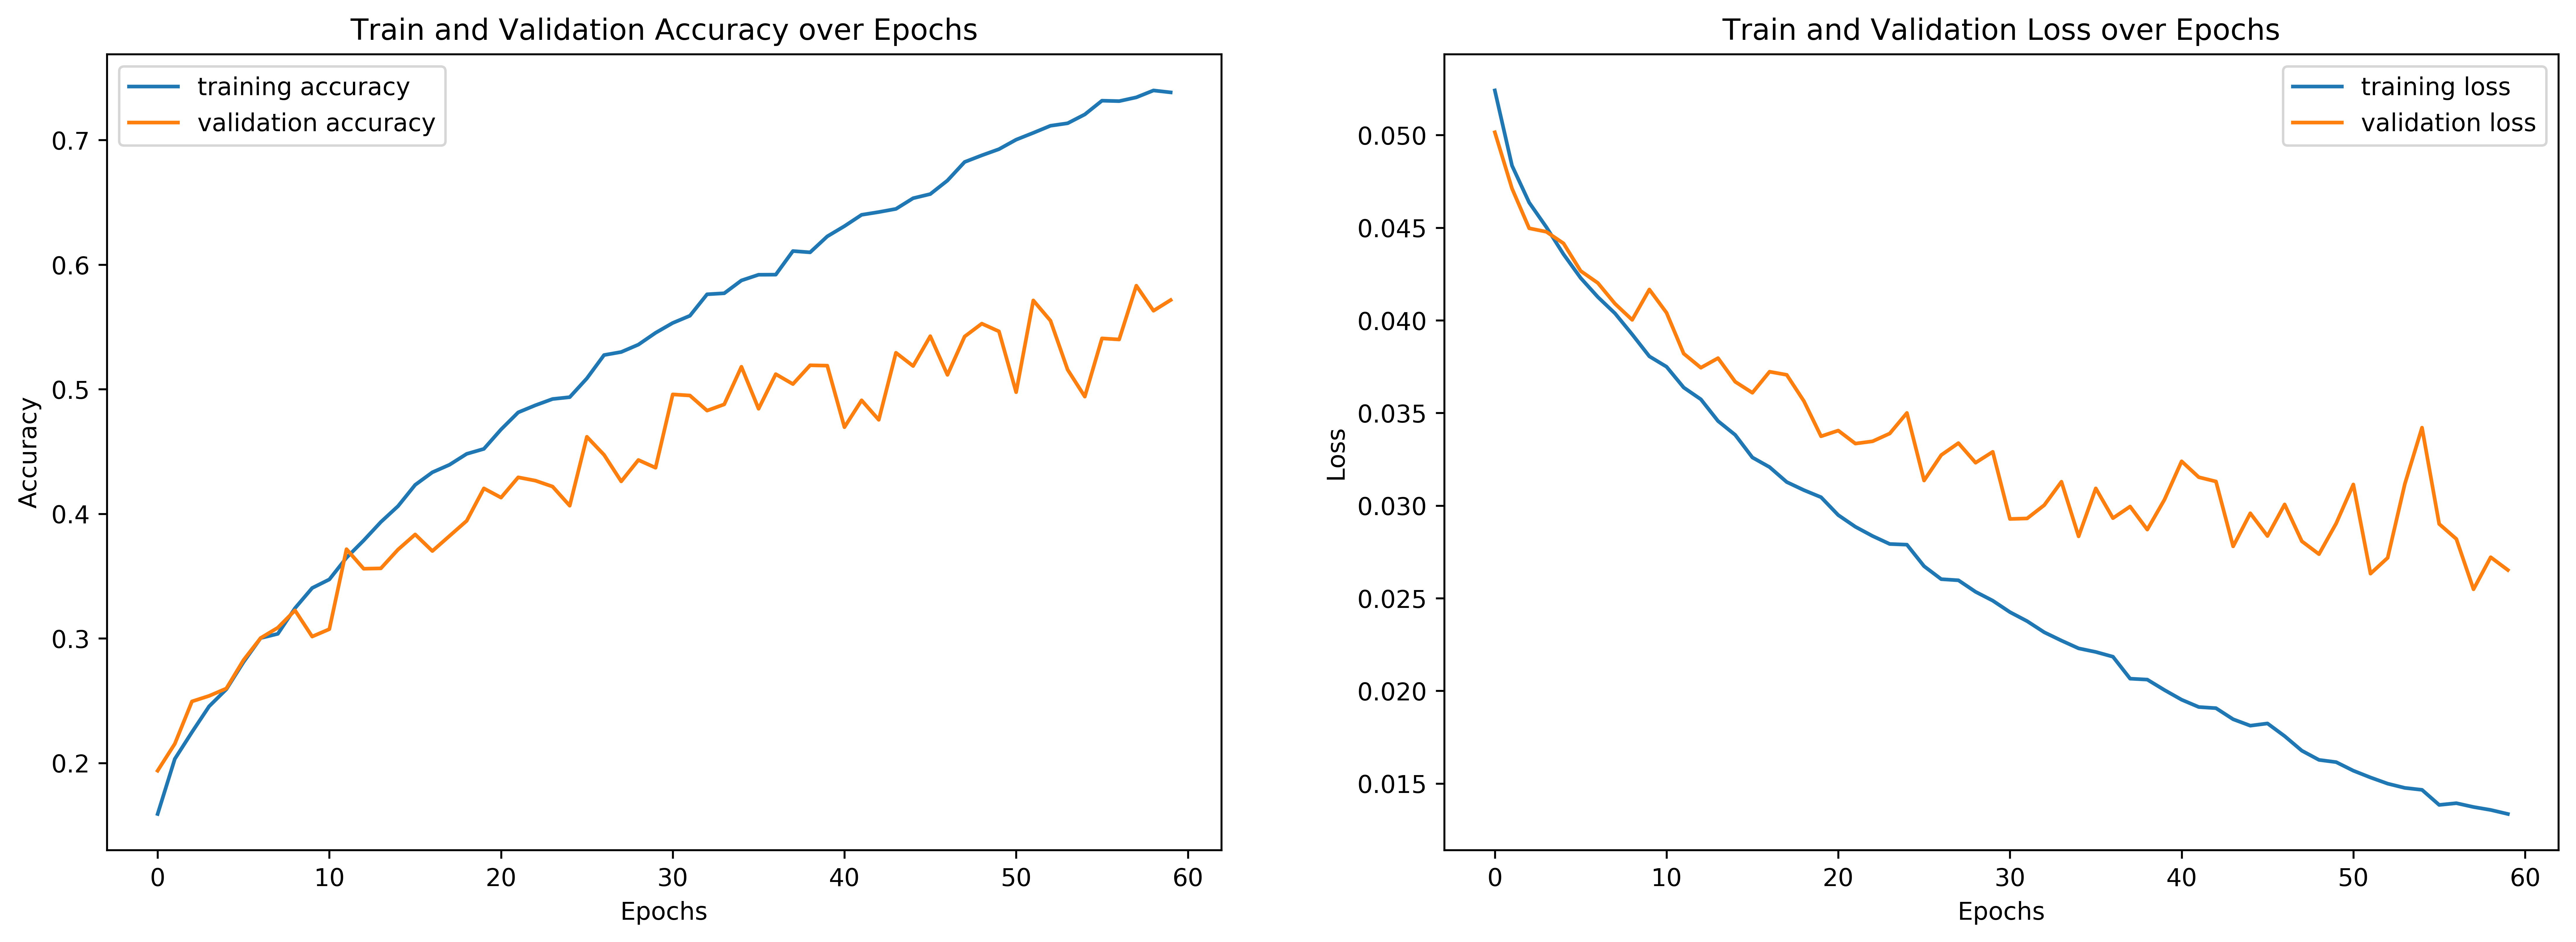

In [0]:
all_train_acc = [l[1] for l in train_ls_acc]
all_train_loss = [l[0] for l in train_ls_acc]
all_val_acc = [l[1] for l in valid_ls_acc]
all_val_loss = [l[0] for l in valid_ls_acc]
plot_result(all_train_acc,all_val_acc,all_train_loss,all_val_loss)